# 02 Experiments:

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()
from openai import OpenAI
import os
import random
import numpy as np

from langchain_openai import OpenAIEmbeddings
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
pd.set_option('display.max_columns',None)

In [ ]:
#Insert an OpenAI-API-key 
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    api_key='')

<h3>Dataset import</h3>

In [8]:
df_feat = pd.read_parquet('https://swp-mvp-media.s3.us-east-1.amazonaws.com/data/02_processed/ABT_feats.parquet')
df_feat.sample()

,USER_ID,FK_GAME_NAME,GAMEPLAY_HOURS,release_from_now,Estimated owners,Peak CCU,Price,DLC count,About the game,Supported languages,Reviews,Achievements,Recommendations,Notes,Categories,Genres,Tags
59114,11940338,blastem,0.0,4050.0,75000.0,0,0.0,1,"I'm halting development on this game, there's ...",['English'],None,23,133,None,"Single-player,Steam Achievements,Steam Leaderb...","Action,Indie","Action,Indie,Shoot 'Em Up,Retro"


<h3> Creating ABT </h3>

In [9]:
######## Customers filters ############
#Only users with at least 15 purchased games and less than 60
gb = df_feat.groupby('USER_ID')['FK_GAME_NAME'].count().reset_index().sort_values('FK_GAME_NAME',ascending=False)
gb=gb[(gb.FK_GAME_NAME>15)&(gb.FK_GAME_NAME<60)]
df_feat = df_feat[df_feat.USER_ID.isin(gb.USER_ID)]
print(df_feat.USER_ID.nunique())

#Setting Tranning and Validation DataSet
# Train 90% of DS size - 775 Users
# Validation 10% of DS size - 86 Users
validation_size = 0.1
validation_IDS = df_feat.groupby('USER_ID').FK_GAME_NAME.count()\
  .reset_index()\
  .sample(int(round(df_feat.USER_ID.nunique()*validation_size,0)), random_state=1)\
  .USER_ID.to_list()


df_train = df_feat[~df_feat.USER_ID.isin(validation_IDS)]
df_validation = df_feat[df_feat.USER_ID.isin(validation_IDS)]

print(df_train.USER_ID.nunique(),df_validation.USER_ID.nunique())

df_train.drop_duplicates(subset=['FK_GAME_NAME'],inplace=True)
df_train.shape

861
775 86


<ipython-input-9-52fa189080d6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop_duplicates(subset=['FK_GAME_NAME'],inplace=True)


(2093, 17)

In [ ]:
############ FILTRO CONTEUDO #################
# print(df_feat.FK_GAME_NAME.nunique())
# df_content = df_feat.drop_duplicates(subset=['FK_GAME_NAME'])
# df_train = df_content.sample(2000, random_state=1)
# df_validation = df_content[~df_content.FK_GAME_NAME.isin(df_train.FK_GAME_NAME)]

# df_train.FK_GAME_NAME.nunique(),df_validation.FK_GAME_NAME.nunique()

2145


(2000, 145)

In [10]:
############ Creating Label ################
purchase_list = df_validation.groupby(['USER_ID','FK_GAME_NAME'])['GAMEPLAY_HOURS'].count().reset_index().sort_values('USER_ID',ascending=False)
purchase_list.drop(columns='GAMEPLAY_HOURS',inplace=True)
df_tmp = purchase_list.groupby('USER_ID')['FK_GAME_NAME'].agg(list).reset_index()
purchase_list = purchase_list.merge(df_tmp, on='USER_ID')
purchase_list.drop(columns='FK_GAME_NAME_x',inplace=True)
purchase_list.rename(columns={'FK_GAME_NAME_y':'FK_GAME_NAME'},inplace=True)
purchase_list.drop_duplicates(subset='USER_ID',inplace=True)
del df_tmp
purchase_list.head()

,USER_ID,FK_GAME_NAME
0,285860790,"[warthunder, hitmanabsolution, assassinscreedr..."
20,281535206,"[falloutnewvegas, pathofexile, nomoreroominhel..."
41,274785080,"[mightmagicheroesonline, fistfuloffrags, magic..."
79,263171804,"[supercratebox, clickerheroes, floatingpoint, ..."
95,227863185,"[planetside2, aftermath, codenamecure, cryoffe..."


<h3> Experiment function </h3>

In [34]:
def feature_test(Feat_tested):

  index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))
  vector_store = FAISS(
      embedding_function=embeddings,
      index=index,
      docstore=InMemoryDocstore(),
      index_to_docstore_id={},
  )

  doc_list=[]
  index_list=[]
  for i in df_train.iterrows():
    about = i[1][Feat_tested]
    ID = i[1]['FK_GAME_NAME']
    doc = Document(
        page_content=str(about),
        )
    doc_list.append(doc)
    index_list.append(ID)

  vector_store.add_documents(
  documents = doc_list,
  ids=index_list
  )

  eval_dict={}
  for i in purchase_list['FK_GAME_NAME']:
    n_context = int(len(i)/2)
    list_inference = random.sample(i, n_context)
    list_VR = list(set(i)-set(list_inference))
    inference = ' '.join(df_games[df_games.FK_GAME_NAME.isin(list_inference)][Feat_tested])

    results = vector_store.similarity_search(
      str(inference),
      k=n_context,
      )
    content_base_rec = [result.id for result  in results]
    content_base_rec = list(set(content_base_rec)-set(list_inference))
    #print(n_context)
    #print('list_inference',list_inference)
    #print('list_VR',list_VR)
    #print('content_base_rec',content_base_rec)
    eval = len(list(set(list_VR).intersection(set(content_base_rec))))/len(list_VR)
    #print('Evaluation',eval)
    eval_dict[str(i)]={}
    eval_dict[str(i)]['purchased']=list_inference
    eval_dict[str(i)]['recommended']=content_base_rec
    eval_dict[str(i)]['evaluation']=eval

  eval_about = pd.DataFrame.from_dict(eval_dict).transpose()
  eval_about['fl_acerto'] = np.where(eval_about.evaluation>0,1,0)

  # METRICS
  print("*"*10,f"{Feat_tested}","*"*10)
  print("Mean of right suggestions: ",eval_about.evaluation.mean())
  print("Mean of users that purchased at least 1 suggestions: ",eval_about.fl_acerto.mean())
  plt.figure(figsize=(8, 4))
  eval_about['evaluation'].hist()
  plt.title('Jaccard similarity score for each user recomendation', fontsize=16)
  plt.xlabel('% of right recommendations', fontsize=14)
  plt.ylabel('Number of users', fontsize=14)
  plt.show()

In [12]:
df_games=df_feat.drop_duplicates(subset='FK_GAME_NAME')

<ipython-input-13-87a4472d414a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['About the game'] = df_games['About the game'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** About the Game **********
Mean of right suggestions:  0.04241323508800128
Mean of users that purchased at least 1 suggestions:  0.4069767441860465


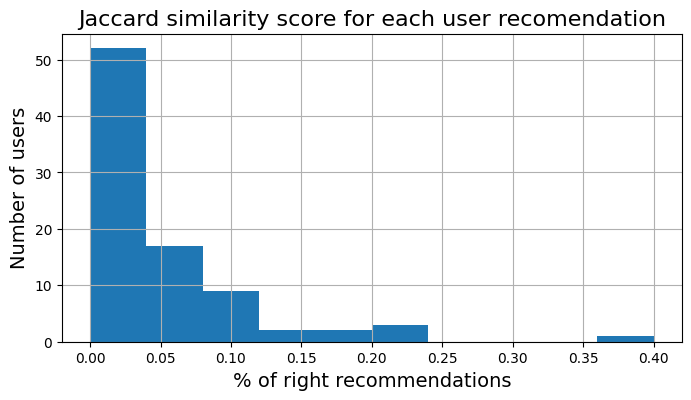

In [13]:
df_games['About the game'] = df_games['About the game'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('About the game')

<ipython-input-15-a452b23e014a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['Tags'] = df_games['Tags'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** Tags **********
Mean of right suggestions:  0.06671101568009254
Mean of users that purchased at least 1 suggestions:  0.5116279069767442


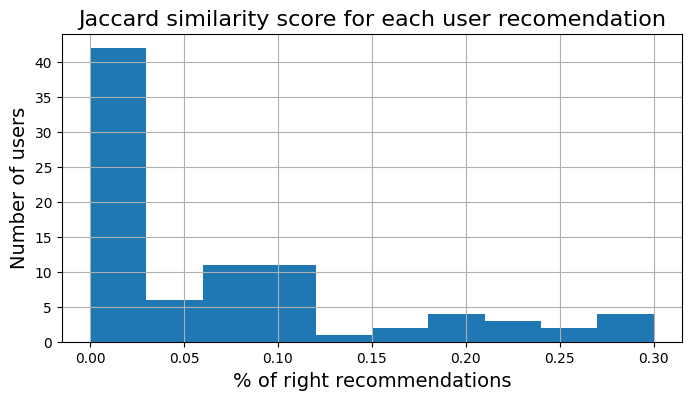

In [15]:
df_games['Tags'] = df_games['Tags'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('Tags')

<ipython-input-17-0a18e8809688>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['Genres'] = df_games['Genres'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** Genres **********
Mean of right suggestions:  0.024349374732026835
Mean of users that purchased at least 1 suggestions:  0.2441860465116279


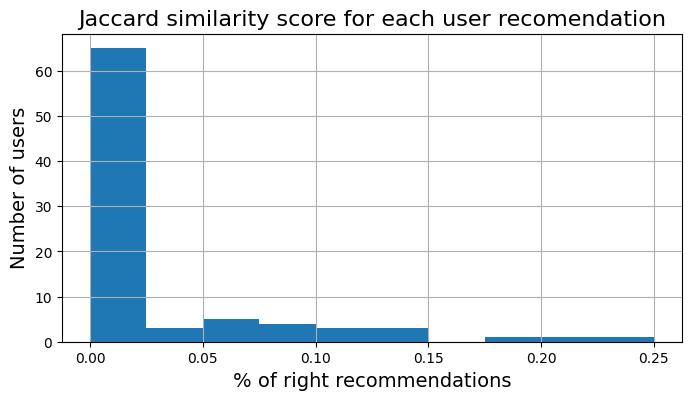

In [17]:
df_games['Genres'] = df_games['Genres'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('Genres')

<ipython-input-19-b9da11fea0cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['Categories'] = df_games['Categories'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** Categories **********
Mean of right suggestions:  0.03155564619171083
Mean of users that purchased at least 1 suggestions:  0.36046511627906974


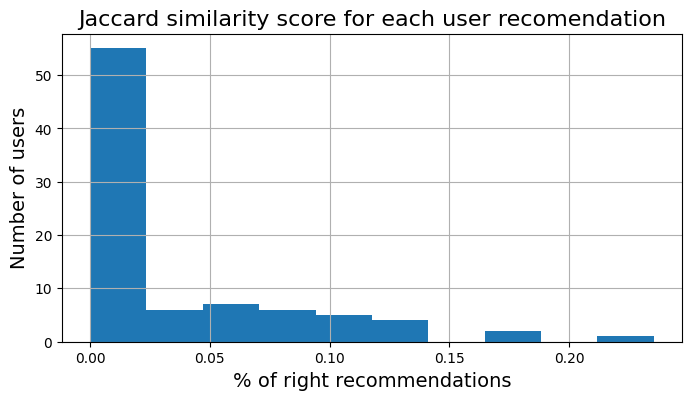

In [19]:
df_games['Categories'] = df_games['Categories'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('Categories')

<ipython-input-21-be149ed4d2da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['Supported languages'] = df_games['Supported languages'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** Supported languages **********
Mean of right suggestions:  0.0523755609138702
Mean of users that purchased at least 1 suggestions:  0.5


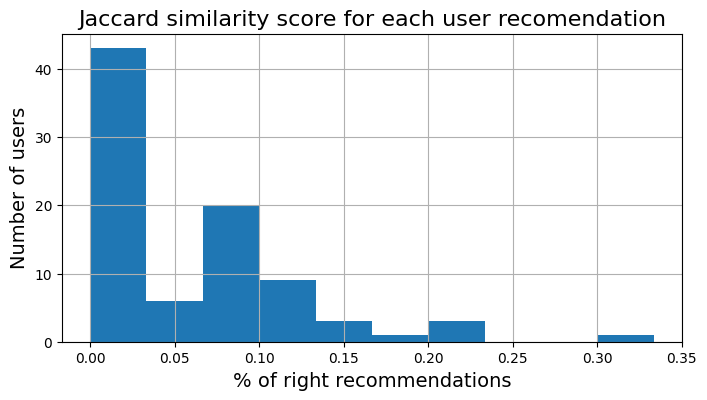

In [21]:
df_games['Supported languages'] = df_games['Supported languages'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('Supported languages')

<h3>Combined features</h3>

<ipython-input-23-bb19a9146ff1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['about_tags'] = df_games['About the game'] + ' ' + df_games['Tags']
<ipython-input-23-bb19a9146ff1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['about_tags'] = df_games['about_tags'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
<ipython-input-23-bb19a9146ff1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

********** Combinating - about game & tags **********
Mean of right suggestions:  0.047779993751759425
Mean of users that purchased at least 1 suggestions:  0.4186046511627907


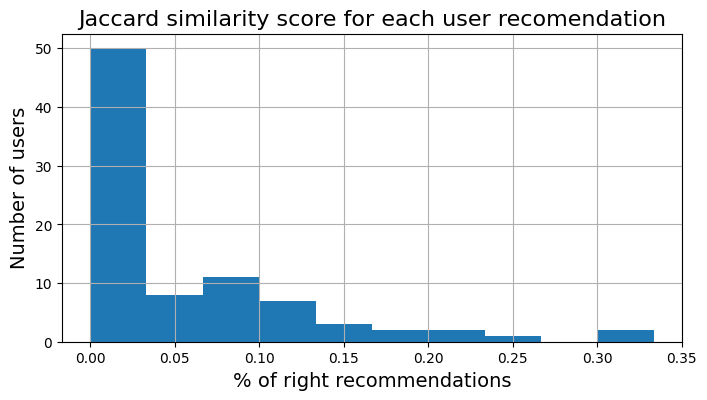

In [23]:
df_games['about_tags'] = df_games['About the game'] + ' ' + df_games['Tags']
df_games['about_tags'] = df_games['about_tags'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

df_train['about_tags'] = df_train['About the game'] + ' ' + df_train['Tags']
df_train['about_tags'] = df_train['about_tags'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('about_tags')

<ipython-input-25-43c71af064e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['about_tags_lang'] = df_games['about_tags'] + ' ' + df_games['Supported languages']
<ipython-input-25-43c71af064e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['about_tags_lang'] = df_games['about_tags_lang'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
<ipython-input-25-43c71af064e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

********** Combinating - tags & languages **********
Mean of right suggestions:  0.06126196299947666
Mean of users that purchased at least 1 suggestions:  0.5813953488372093


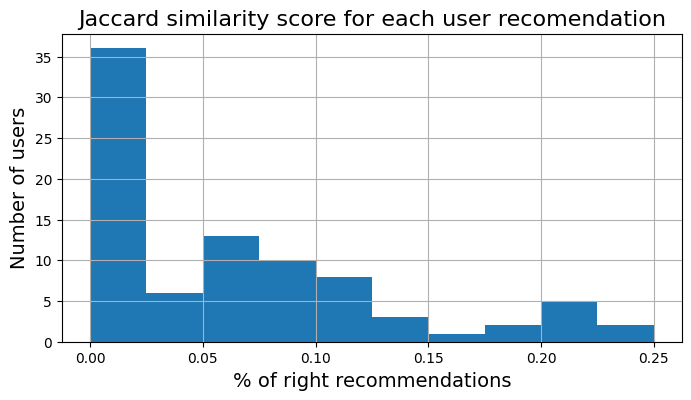

In [25]:
df_games['about_tags_lang'] = df_games['about_tags'] + ' ' + df_games['Supported languages']
df_games['about_tags_lang'] = df_games['about_tags_lang'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

df_train['about_tags_lang'] = df_train['about_tags'] + ' ' + df_train['Supported languages']
df_train['about_tags_lang'] = df_train['about_tags_lang'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

feature_test('about_tags_lang')

<ipython-input-28-fdf7d742f414>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['about_tags_lang_cat'] = df_games['about_tags_lang'] + ' ' + df_games['Categories']
<ipython-input-28-fdf7d742f414>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['about_tags_lang_cat'] = df_games['about_tags_lang_cat'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
<ipython-input-28-fdf7d742f414>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

********** Combinating - About game & tags & languages & Catgories **********
Mean of right suggestions:  0.05695560796084095
Mean of users that purchased at least 1 suggestions:  0.47674418604651164


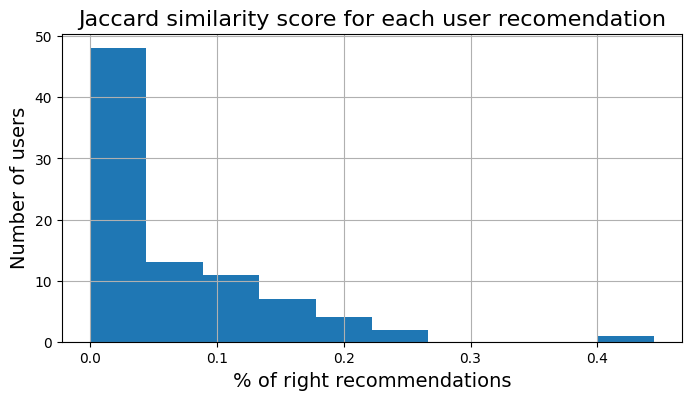

In [28]:
df_games['about_tags_lang_cat'] = df_games['about_tags_lang'] + ' ' + df_games['Categories']
df_games['about_tags_lang_cat'] = df_games['about_tags_lang_cat'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

df_train['about_tags_lang_cat'] = df_train['about_tags_lang'] + ' ' + df_train['Categories']
df_train['about_tags_lang_cat'] = df_train['about_tags_lang_cat'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

feature_test('about_tags_lang_cat')

In [ ]:
#################################################################################################

<ipython-input-32-a77879e6181f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['release_from_now'] = df_train['release_from_now'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
<ipython-input-32-a77879e6181f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['release_from_now'] = df_games['release_from_now'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** {Feat_tested} **********
Mean of right suggestions:  0.010659165028561797
Mean of users that purchased at least 1 suggestions:  0.1511627906976744


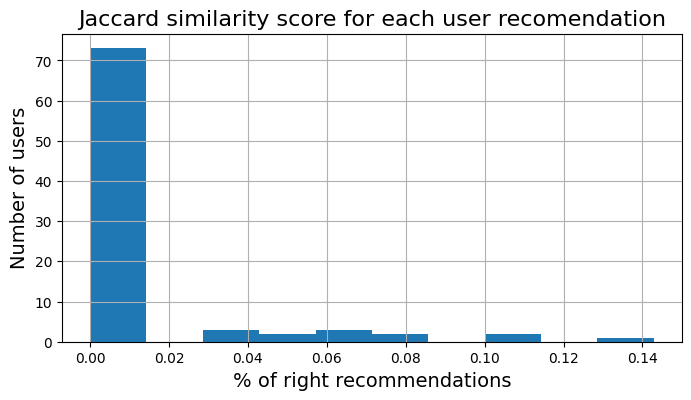

In [32]:
df_train['release_from_now'] = df_train['release_from_now'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
df_games['release_from_now'] = df_games['release_from_now'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('release_from_now')

<ipython-input-33-613e999180a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Estimated owners'] = df_train['Estimated owners'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
<ipython-input-33-613e999180a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['Estimated owners'] = df_games['Estimated owners'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** {Feat_tested} **********
Mean of right suggestions:  0.07932419861469704
Mean of users that purchased at least 1 suggestions:  0.6511627906976745


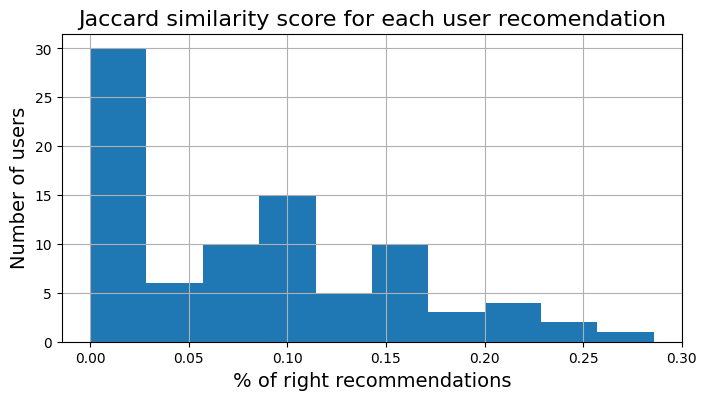

In [33]:
df_train['Estimated owners'] = df_train['Estimated owners'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
df_games['Estimated owners'] = df_games['Estimated owners'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('Estimated owners')

<ipython-input-35-07e332830959>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Price'] = df_train['Price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
<ipython-input-35-07e332830959>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['Price'] = df_games['Price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** Price **********
Mean of right suggestions:  0.03548881045009835
Mean of users that purchased at least 1 suggestions:  0.32558139534883723


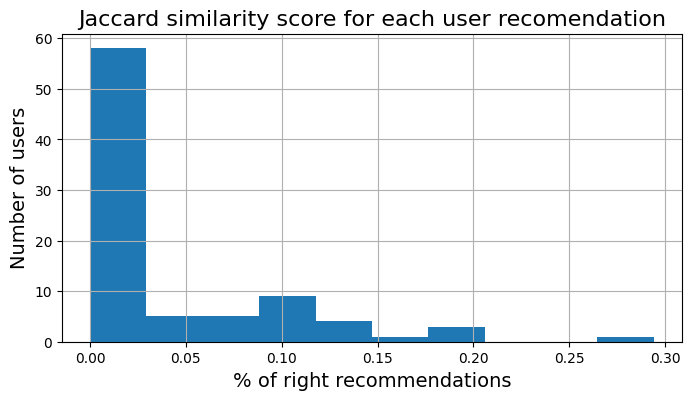

In [35]:
df_train['Price'] = df_train['Price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
df_games['Price'] = df_games['Price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('Price')

<ipython-input-36-09ffee3bc3a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Peak CCU'] = df_train['Peak CCU'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
<ipython-input-36-09ffee3bc3a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['Peak CCU'] = df_games['Peak CCU'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


********** Peak CCU **********
Mean of right suggestions:  0.04289468408471043
Mean of users that purchased at least 1 suggestions:  0.43023255813953487


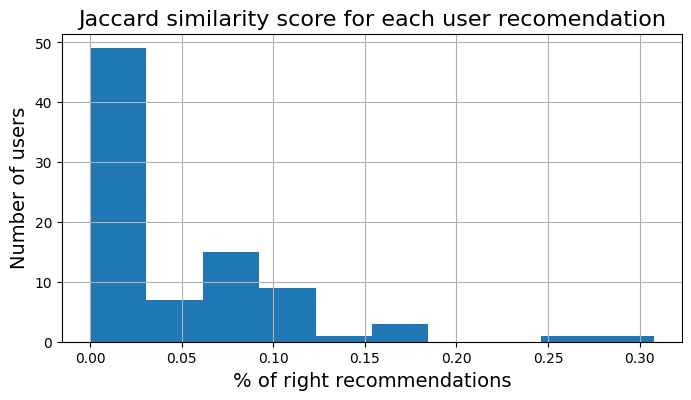

In [36]:
df_train['Peak CCU'] = df_train['Peak CCU'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
df_games['Peak CCU'] = df_games['Peak CCU'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
feature_test('Peak CCU')

<ipython-input-37-2fe1b4f79495>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['EstimOWN_price'] = df_games['Estimated owners'] + ' ' + df_games['Price']
<ipython-input-37-2fe1b4f79495>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['EstimOWN_price'] = df_games['EstimOWN_price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')
<ipython-input-37-2fe1b4f79495>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


********** EstimOWN_price **********
Mean of right suggestions:  0.08786224006015594
Mean of users that purchased at least 1 suggestions:  0.6627906976744186


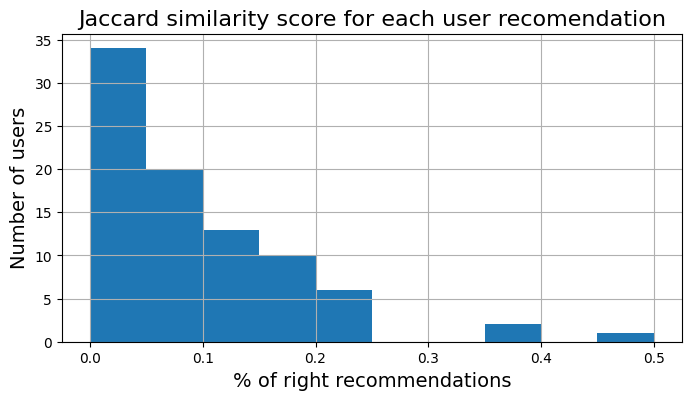

In [37]:
df_games['EstimOWN_price'] = df_games['Estimated owners'] + ' ' + df_games['Price']
df_games['EstimOWN_price'] = df_games['EstimOWN_price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

df_train['EstimOWN_price'] = df_train['Estimated owners'] + ' ' + df_train['Price']
df_train['EstimOWN_price'] = df_train['EstimOWN_price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

feature_test('EstimOWN_price')

********** tg_lg_est_price **********
Mean of right suggestions:  0.06930507934764592
Mean of users that purchased at least 1 suggestions:  0.5813953488372093


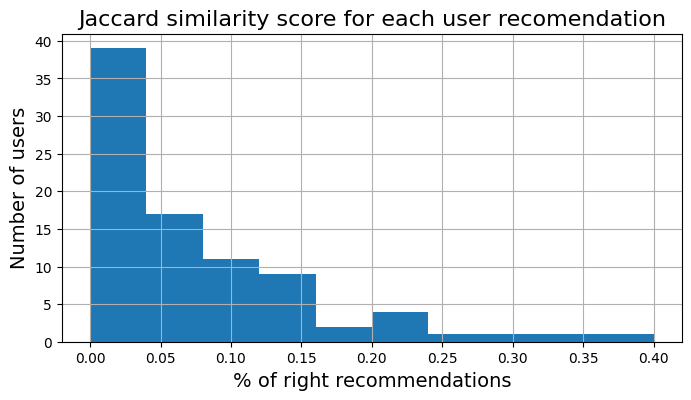

In [44]:
df_games['tg_lg_est_price'] = df_games['Tags'] + ' ' + df_games['Supported languages'] + ' ' + df_games['EstimOWN_price']
df_games['tg_lg_est_price'] = df_games['tg_lg_est_price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

df_train['tg_lg_est_price'] = df_games['Tags'] + ' ' + df_games['Supported languages'] + ' ' + df_games['EstimOWN_price']
df_train['tg_lg_est_price'] = df_train['tg_lg_est_price'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

feature_test('tg_lg_est_price')